<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/1d_poisson_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Model noise with Poisson statistics in 1D

# Resources
* (2017. Single-protein detection in crowded molecular environments in cryo-EM images. eLife)[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5453696/]
  * Comments on Poisson statistics, and simulation of data with forward model (using poisson stats?)


In [ ]:
%%bash
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-9243/map/emd_9243.map.gz
gunzip emd_9243.map.gz
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
pip install pyfftw

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mrc
from twod import *
from scipy.ndimage import rotate

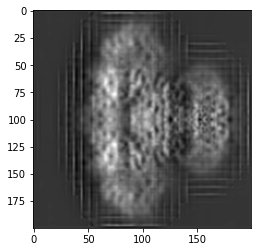

In [129]:
fname = 'emd_9243.map'#'/content/drive/My Drive/repos/learn_cryoem_math/data/ouhn_Data1_P1/emd_9243_downsample_64pix.mrc'#emd_9243_downsample_128pix_lp3A.mrc.mrc'#'emd_9243.map'
vol = mrc.read(fname)
A = vol.mean(0)
A = (A - A.min()) / (A.max()-A.min())
nx, ny = A.shape
assert nx == ny
plt.imshow(A,cmap='gray')

# Simulate data with Poisson Noise
We can simulate the data with poisson noise. The scaling factor simulates the electron dose. At low dose we get noisy images (which is what we'd typically use to preserve the fragile specimen).

## Additive noise
The poisson noise is an integer value, governed by the parameter $\lambda$, which is taken to be on the scale of $A$ (the mean of $A$, multipled by a constant), where c is some constant so that the image visually looks noisy.
$$X_{i \alpha} = A_\alpha + N_{poisson}$$
$$P(N_{poisson} = k | \lambda) = \lambda^ke^{-\lambda}/k!$$

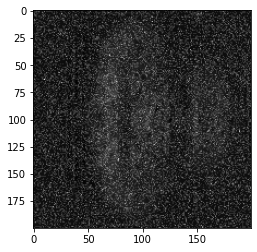

In [1004]:
scale=2
noise_scale = 1
A_true_scaled = scale*A
lam = A_true_scaled.mean()*noise_scale
noise = np.random.poisson(lam=lam, size=A.size).reshape(A.shape)
x = A_true_scaled + noise
do_2dplot(x)

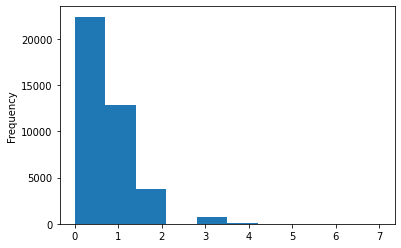

In [1005]:
pd.Series(noise.flatten()).plot.hist()

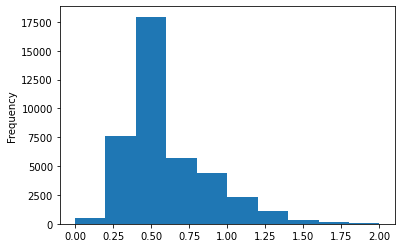

In [1006]:
pd.Series(A_true_scaled.flatten()).plot.hist()

### Batch

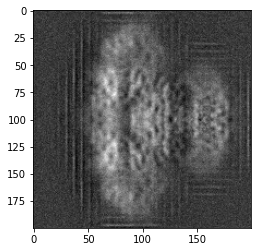

In [1010]:
scale=3
noise_scale = 1
A_true_scaled = scale*A
lam = A_true_scaled.mean()*noise_scale

N=50
X = np.zeros((N,)+A.shape)
for i in range(N):
  X[i] = A_true_scaled + np.random.poisson(lam=lam, size=A.size).reshape(A.shape)

  
A_prev = X.mean(0)
do_2dplot(A_prev)

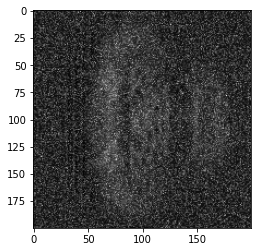

In [916]:
do_2dplot(X[0])

0.001662000000000009

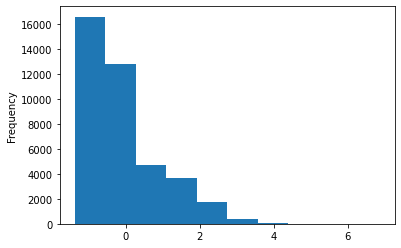

In [1011]:
xminusA = X[0] - A_prev
#do_2dplot(xminusA)
pd.Series(xminusA.flatten()).plot.hist()
xminusA.mean()


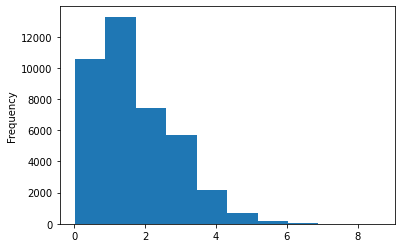

In [1012]:
pd.Series(X[0].flatten()).plot.hist()


The noise is always a positive number, so we need to check that we are defining our observed images and true image in a way that gets rid of bias. Here we see the difference centred around a mean of zero, so we are OK.

## Mean $\lambda=A_\alpha$

0 0 1 0
1 0 2 1
2 1 0 2
3 1 1 0
4 1 2 1
5 2 0 2
6 2 1 0
7 2 2 1
8 3 0 2
9 3 1 0
10 3 2 1
11 4 0 2
12 4 1 0
13 4 2 1
14 5 0 2
15 5 1 0


Text(0.5, 1.0, 'ground truth')

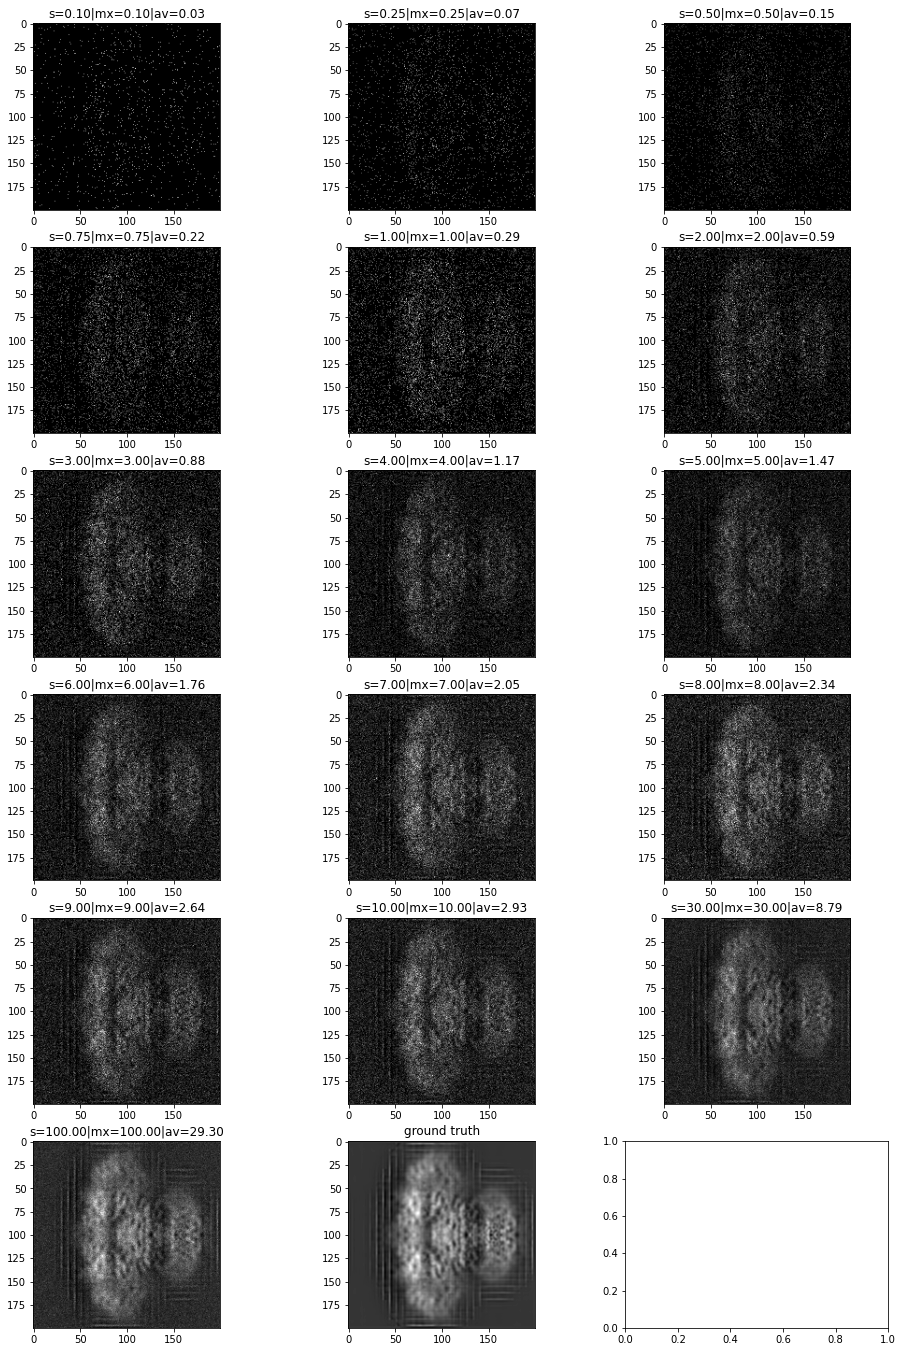

In [672]:
scales = [0.1,0.25,0.5,0.75] + list(range(1,10)) + [10,30,100]
fig, axes = plt.subplots(np.ceil((len(scales)+1)/3).astype(int),3, figsize=(16,24))

r=0
c=0
for i, scale in enumerate(scales):
  X = np.random.poisson(A*scale)
  axes[r,c].imshow(X,cmap='gray') ; axes[r,c].set_title('s=%.2f|mx=%1.2f|av=%1.2f' % (scale,(A*scale).max(), (A*scale).mean()))
  if (i+1)%3 == 0: 
    c=0
    r+=1
  else:
    c+=1
  print(i,r,c,i%3)
axes[r,c].imshow(A,cmap='gray') ; axes[r,c].set_title('ground truth')


I can see features starting to appear around scale 0.75. There are unrealisticly good features at scale 7 and above (from my experience).

### Batch
Perhaps unintuitively (visually), if we average many noisy images together, even at a very small scale, we do recover the original image!

It remains to be seen how the alignment probabilities work at low noise.

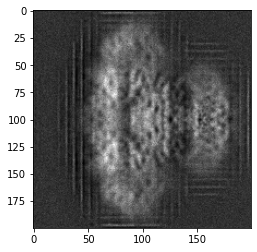

In [673]:
scale=0.75
N=300
X = np.zeros((N,)+A.shape)
for i in range(N): 
  X[i] = np.random.poisson(lam=A*scale)
  
A_prev = X.mean(0)
do_2dplot(A_prev)

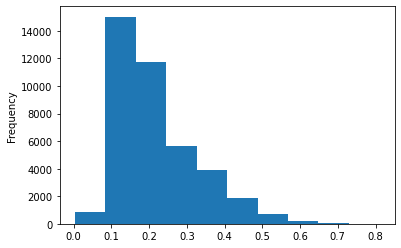

In [729]:
pd.Series(A_prev.flatten()).plot.hist()

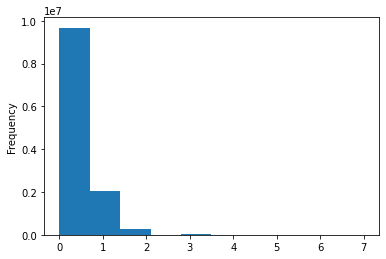

In [730]:
pd.Series(X.flatten()).plot.hist()

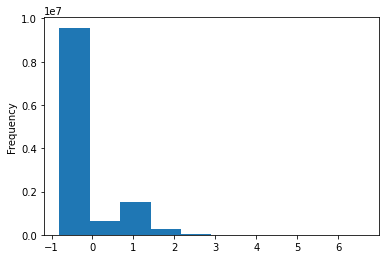

In [733]:
pd.Series((X-A_prev).flatten()).plot.hist()

In [734]:
(X-A_prev).flatten().min()

-0.81

## rotate 
* when the particles are randomly rotated (uniform distribution), much of our information washes out

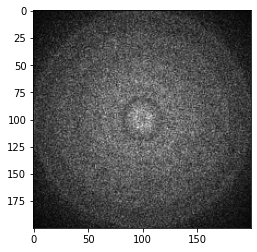

In [460]:
true_angles = np.random.uniform(0,360,size=N)
for i in range(N): 
  X[i] = rotate(X[i],angle=true_angles[i],reshape=False)
do_2dplot(X.mean(0))

# 2D Classification: EM Algorithm (with Poisson Additive Noise)
$$
A_\alpha^{\text{new}} = \frac
{
  -N(\ln \lambda + \gamma_{em}) +
  \sum_i Z_i^{-1} \int dq_i \gamma_i \sum_{k=1}^\infty \frac
  {
    X_{i\alpha}
  }
  {
    k(k+X_{i\alpha}-A_\alpha^{\text{old}})
  }
}
{
  \sum_i Z_i^{-1} \int dq_i \gamma_i \sum_{k=1}^\infty \frac
  {
    1
  }
  {
    k(k+X_{i\alpha}-A_\alpha^{\text{old}})
  }
}
$$
* $Z=\int dq_i \gamma_i$
* $\gamma_{em}$ is the [Euler-Mascheroni Constant](https://mathworld.wolfram.com/Euler-MascheroniConstant.html) ($\approx 0.577_2$)
* For the derivative of $(X_{i\alpha}-A_\alpha)!$, see [this video proof from Flammable Maths (2019)](https://youtu.be/kjK9WfmLElo)


$$A_{\alpha} = N^{-1}\sum_i \frac{
  \int dq_i \gamma_i X_{i\alpha}}
  {\int dq_i \gamma_i}
  $$
Where $\gamma_i$ is given by Poisson statistics
$$\gamma_i = p({\bf q_i})\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}e^{-A_\alpha}}{X_{i\alpha}!} \\ 
= p({\bf q_i})
e^{-\sum_\alpha A_\alpha}
\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}}{X_{i\alpha}!}
$$
* A is modified by the alignment operator, but this is not shown for brevity
* $p({\bf q_i})$ is the prior probability of the alignment ${\bf q_i}$

## Reference aligned templates

In [1013]:
deg_step=1
angles = np.arange(0,360,deg_step)
A_rot = np.zeros((nx,nx,angles.shape[0]))

for angle_idx, angle in enumerate(angles):
  A_rot[:,:,angle_idx] = rotate(A_prev,angle=angle, reshape=False)

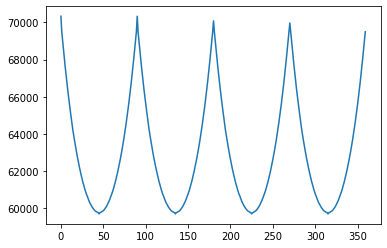

In [1014]:
A_aligned_norm = np.sum(A_rot[:,:,:],axis=(0,1))
do_1dplot(A_aligned_norm)


In [965]:
(A_aligned_norm.max() - A_aligned_norm.min()) / A_aligned_norm.mean() * 100

13.64649241742319

## $\gamma_i$
$$\gamma_i = \prod_\alpha \lambda^{X_{i\alpha}-A_\alpha}e^\lambda / (X{i\alpha}-A_\alpha)!$$

In [1019]:
x=X[0]
x_minus_A = np.abs((x-A_prev))
np.power(lam,x_minus_A.sum(), dtype=np.float128)

1.2449827323890090509e-1633

In [1020]:
np.power(lam,x_minus_A[0,0], dtype=np.float128)

0.96456211992902653174

In [1021]:
np.exp(-lam,dtype=np.float128)

0.4151579330387143355

In [1022]:
from scipy.special import gamma

gamma(x_minus_A.max()+1), gamma(x_minus_A.min()+1)

(3805.811302093142, 1.0)

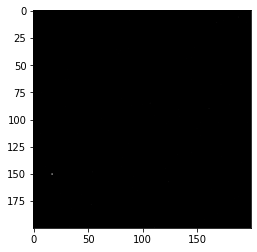

In [1023]:
do_2dplot(gamma(x_minus_A+1))

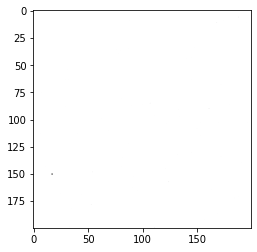

In [1025]:
log_gamma_i_kernel = x_minus_A*np.log(lam)-lam - gamma(x_minus_A+1)
do_2dplot(log_gamma_i_kernel)

In [927]:
np.sum(gamma(x_minus_A+1),dtype=np.float128)

99220.0

Let's check that everything is finite, and we are not having numerical issues.

In [1026]:
#x_minus_A[~np.isfinite(gamma(x_minus_A+1))]
x_minus_A[~np.isfinite(log_gamma_i_kernel)]

array([], dtype=float64)

The gamma function should not be taking negative values, as it may give complex infinity at these points. We cannot use the Poisson distribution formula to model noise that is not positive. The formula is not valid for negative values of k (k! is not defined).

The values in `log_gamma_i_kernel` are not that large, but the sum is over so many pixels, that it cannot be exp-ed with numerical stability.

Instead we can divide out a common factor from the $\gamma_i$ terms. We can look at the range of $\gamma_i$ for all the alignments and normalize things so we are within range for the most likely ones. 

-89051.2616504669

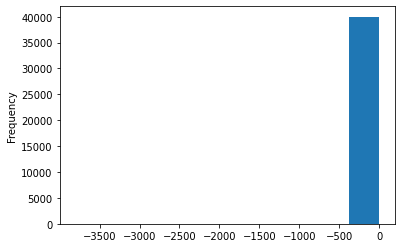

In [1027]:
pd.Series(log_gamma_i_kernel.flatten()).plot.hist()
log_gamma_i_kernel.sum()

### $\gamma_i$ vectorized over alignments

In [1028]:
x=X[0]
x_minus_A = np.abs((x.reshape(x.shape+(1,))-A_rot))
x_minus_A.shape

(200, 200, 360)

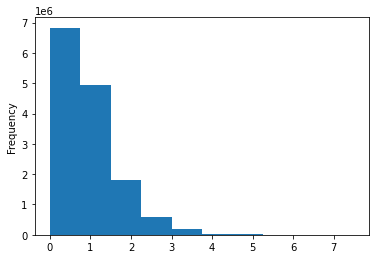

In [1029]:
pd.Series(x_minus_A.flatten()).plot.hist()

How do we go further at this point? It's confusing because the rotations make the noise be negative, and the Poisson statistice break down. 

Perhaps we could introduce a heuristic, that any alignments where the difference is negative have zero probability. But then we see that only the first perfectly aligned template satisfies this.

In [1030]:
x_minus_A.min(axis=(0,1)) < 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [1031]:
log_gamma_i_kernel = x_minus_A*np.log(lam)-lam - gamma(x_minus_A+1)
log_gamma_i_kernel_sum = log_gamma_i_kernel.sum(axis=(0,1))
log_gamma_i_kernel_sum_stable = (log_gamma_i_kernel_sum - log_gamma_i_kernel_sum.max()+11355).astype(int)
np.logical_and(log_gamma_i_kernel_sum_stable < 11355, log_gamma_i_kernel_sum_stable > -11380)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True, False, False,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,

In [1049]:
np.exp(log_gamma_i_kernel_sum_stable, dtype=np.float128)

array([2.59323582e+4931, 8.81517703e+2098, 8.80530601e+2640,
       4.29362116e+0210, 1.05011623e+1335, 5.23994941e+0249,
       3.00377787e-0116, 1.30103830e-0566, 2.22075204e-0386,
       4.04107368e-0811, 1.71140136e-2877, 7.49712945e-1669,
       1.14309130e-2218, 7.44434246e-1821, 1.58929844e-2771,
       0.00000000e+0000, 2.77042799e-3837, 2.51923703e-2485,
       6.10674179e-2402, 3.92051454e-4010, 1.10980095e-3986,
       2.69821566e-3556, 1.12559570e-3682, 7.68221015e-4541,
       0.00000000e+0000, 3.71607765e-4879, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000,

## Precompute $\sum_k$ terms
* consider making a `ufunc`, so can use on vector of $X_i-A$ (over all $\alpha$ values). If we only have a few values of `x_minus_A`, then we can precompute for these values of k and look them up in a table.
* Actually these have been calculated analytically (taking k to infinity in [this online Series Calculator](https://www.symbolab.com/solver/series-calculator))

|x|ksum|
|-|-|
|1|1|
|2|3/4|
|3|11/18|
|4|25/48|
|5|137/300|
|6|49/120|
|k|$H_k/k$ ($H_k$ is the $k$th Harmonic number)|

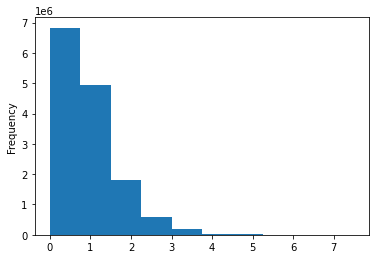

In [1032]:
x = X[0]
k_poisson = x_minus_A
pd.Series(k_poisson.flatten()).plot.hist()

TypeError: ignored

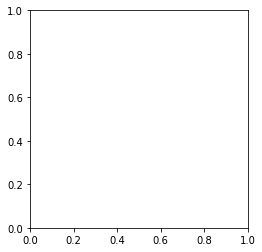

In [989]:
do_2dplot(k_poisson)

0.9899999999999997

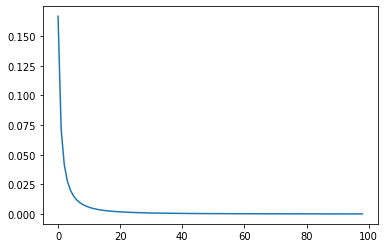

In [951]:
kpa = 5#k_poisson[0,0]
k = np.arange(1,100,1)
kseries = 1/(k*(k+kpa))
pd.Series(kseries).plot()
kseries.sum()

def ksum(k,x): 
  '''
  k is over 1 to infinity. in practice truncate at k=100, etc
  '''
  return(np.sum(np.power(k*(k+x),-1,dtype=np.float128)))
  #return((1/(k*(k+x))).sum())

def ksum_analytic(x):
  '''
  when x is an integer we can use the analytical result. See https://www.wolframalpha.com/input/?i=infinite+series&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumlowerlimit%22%7D+-%3E%221%22&assumption=%7B%22C%22%2C+%22infinite+series%22%7D+-%3E+%7B%22Calculator%22%7D&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumfunction%22%7D+-%3E%221%2F%28x*%28x%2Bk%29%29%22&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumupperlimit2%22%7D+-%3E%22infinity%22
  '''
  if np.isclose(x,0): return(np.pi**2/6)
  Hx = (1/np.arange(1,x+1)).sum()
  return(Hx/x)
ksum(k,1)

In [1046]:
x_minus_A_uniq = np.unique(x_minus_A)
precomputed_ksum = np.zeros(x_minus_A_uniq.shape[0], dtype=np.float128)
for i in range(precomputed_ksum.shape[0]):
  precomputed_ksum[i] = ksum(k,x_minus_A_uniq[i])
#precomputed_ksum = {x: ksum_analytic(x) for x in np.unique(x_minus_A)}


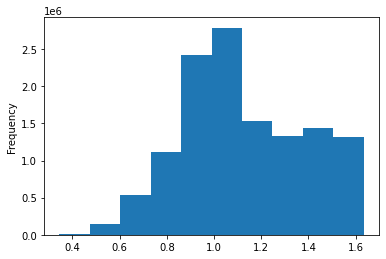

In [1047]:
pd.Series(precomputed_ksum).plot.hist()

We can compare this to the result using the truncated ksum function.

# 2D Classification: EM Algorithm (with Poisson Noise)
$$A_{\alpha} = N^{-1}\sum_i \frac{
  \int dq_i \gamma_i X_{i\alpha}}
  {\int dq_i \gamma_i}
  $$
Where $\gamma_i$ is given by Poisson statistics
$$\gamma_i = p({\bf q_i})\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}e^{-A_\alpha}}{X_{i\alpha}!} \\ 
= p({\bf q_i})
e^{-\sum_\alpha A_\alpha}
\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}}{X_{i\alpha}!}
$$
* A is modified by the alignment operator, but this is not shown for brevity
* $p({\bf q_i})$ is the prior probability of the alignment ${\bf q_i}$

## Reference aligned templates
* Also compute sums over all pixels (instead of norm)

In [674]:
deg_step=1
angles = np.arange(0,360,deg_step)
A_rot = np.zeros((nx,nx,angles.shape[0]))

for angle_idx, angle in enumerate(angles):
  A_rot[:,:,angle_idx] = rotate(A_prev,angle=angle, reshape=False)

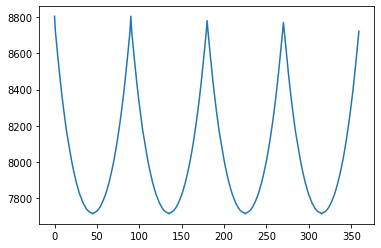

In [675]:
A_aligned_norm = np.sum(A_rot[:,:,:],axis=(0,1))
do_1dplot(A_aligned_norm)


In [676]:
(A_aligned_norm.max() - A_aligned_norm.min()) / A_aligned_norm.mean() * 100

13.58890474421172

The sums of A fluctuate within 13% error, which is quite a lot!

## $\gamma_i$
* Numerical stability
  * Note that the $\prod_\alpha X{i \alpha}!$ in $\gamma_i$ can be factored out of the integral. There is one in the numerator and denomenator of the update equation for $A_\alpha$, which cancel out with each other.
  * Therefore we compute a scaled $\gamma_i$ below, without this factor 

(1.76899628492943, 1.0603013796085798)

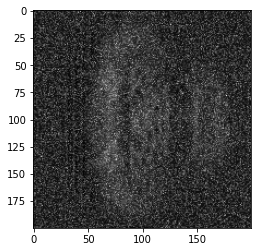

In [919]:
x = X[0]
do_2dplot(x)
x.mean(), x.std()**2

### $A_\alpha^{X_{i \alpha}}$
* Note that `np.power(0,0) = 1` by definition, and it works the same way on vectors.

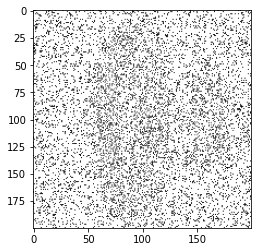

In [678]:
Atox = np.power(A_prev,x)
do_2dplot(Atox)

0.0

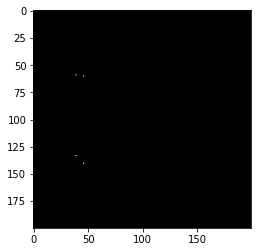

In [679]:
do_2dplot(np.isclose(A_prev,0))
np.prod(A_prev)

We can modify $A$ to have a small term to offset zeros. We can use the number closest to zero. 

In [680]:
A_nonzero_min = A_prev[A_prev>0].min()
A_prev[np.isclose(A_prev,0)] = A_nonzero_min

(0.0008352100000000003, 1.0, 0.0)

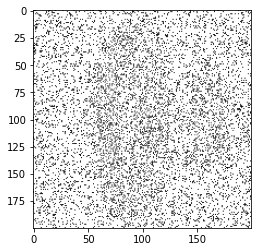

In [681]:
Atox = np.power(A_prev,x)
do_2dplot(Atox)
Atox.min(), Atox.max(), np.prod(Atox)

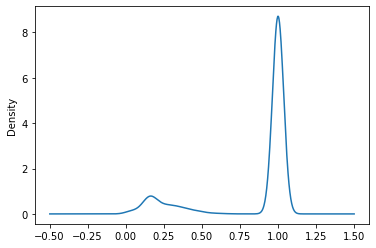

In [682]:
pd.Series(Atox.flatten()).plot.kde()

I think that the terms around zero are forcing the product to zero. Perhaps 

###$e^{A_\alpha}$
* We can either compute this within the product sum, by multiplying it with $A_\alpha^{X_{i \alpha}}$, or we can pull it out of the product sum and sum over alpha, $e^{-\sum_\alpha A_\alpha}$

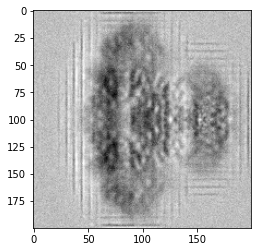

In [683]:
etoA = np.exp(-A_prev)
do_2dplot(etoA)

In [684]:
etoA.min(), etoA.max()

(0.4448580662229411, 0.9966722160545233)

In [688]:
np.prod(etoA.astype(np.float128))

4.5025656056117267778e-3825

In [686]:
Asum = A_prev.sum() ; Asum

8805.883333333333

In [689]:
np.exp(-Asum.astype(np.float128))

4.5025656056110200628e-3825

We have a problem, because we can only compute $[e^{-745},e^{709}]$ in default precision.

However, if we encode a number as `np.float128` we can reach at least $[e^{-11380},e^{11355}]$

* See discussion https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


(-11379.999999999949686, -inf, -744.4400719213812, -inf)

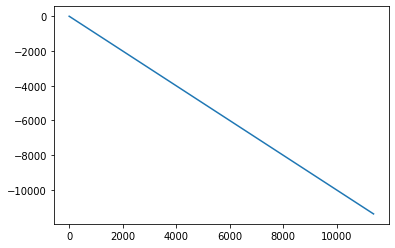

In [565]:
dom = np.linspace(0,11380,100, dtype=np.float128)
#sr = pd.Series((np.isclose(np.exp(-dom),0)).astype(np.int))
sr = pd.Series(np.log(np.exp(-dom)))
sr.index = dom
sr.plot()
np.log(np.exp(np.float128(-11380))), np.log(np.exp(np.float128(-11400))),\
np.log(np.exp(np.float64(-745))), np.log(np.exp(np.float64(-746)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


(11355.0, inf, 709.0, inf)

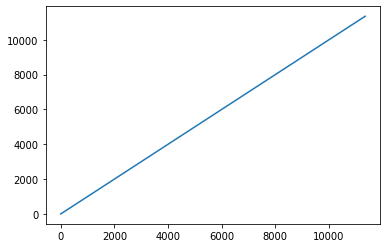

In [618]:
dom = np.linspace(0,11355,100, dtype=np.float128)
#sr = pd.Series((np.isclose(np.exp(-dom),0)).astype(np.int))
sr = pd.Series(np.log(np.exp(dom)))
sr.index = dom
sr.plot()
np.log(np.exp(np.float128(11355))), np.log(np.exp(np.float128(11360))),\
np.log(np.exp(np.float64(709))), np.log(np.exp(np.float64(710)))


If we try to compute $A_\alpha^{X_{i\alpha}}e^{-A_\alpha}$ together, pixel by pixel, we cannot take the product after, since the values are too small.

(0.0007046372914694659, 0.9966722160545233, 0.6899193392862865, 0.0)

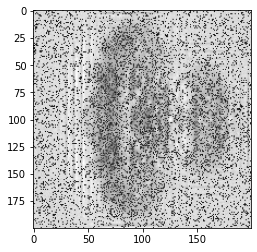

In [691]:
AxeA = Atox*etoA
do_2dplot(Atox*etoA)
AxeA.min(), AxeA.max(), AxeA.mean(), np.prod(AxeA.astype(np.float128))


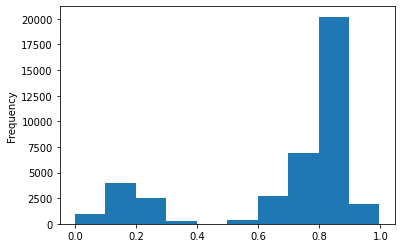

In [692]:
pd.Series(AxeA.flatten()).plot.hist()

0.0

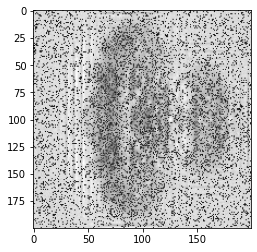

In [693]:

do_2dplot(AxeA / AxeA.min() / AxeA.size)
np.prod(AxeA / AxeA.min() / AxeA.size)

### Numerical stability
* exp log for large values?
* log exp for small values?
* $\gamma_i$ is too small here, so let's use $log$ to break up the product sum
$$\ln[\prod_\alpha A^{X_{i \alpha}}e^{-A_\alpha}] \\
= \sum_\alpha X_{i \alpha} \ln(A_\alpha) - A_\alpha
$$
* I can offset this sum by a constant, K, chosen such that the number that will be exp-ed is within the numerically stable range
$$K \text{ s.t. } \sum_\alpha X_{i \alpha} \ln(A_\alpha) - A_\alpha - K \in [-745,+709]$$

The log is not blowing up to negative infinity

In [694]:
np.log(A_prev).min(), np.log(A_prev).max()

(-5.703782474656201, -0.21072103131565253)

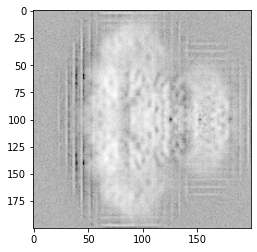

In [695]:
do_2dplot(np.log(A_prev))

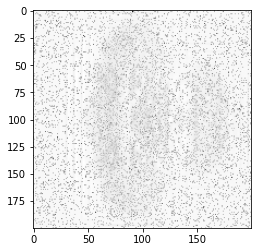

In [696]:
do_2dplot(x*np.log(A_prev) - A)

In [697]:
log_gi = x*np.log(A_prev) - A
log_gi.max(), log_gi.min()

(-0.0, -7.300487650577766)

(0.0006752094286293653, 1.0, 0.0)

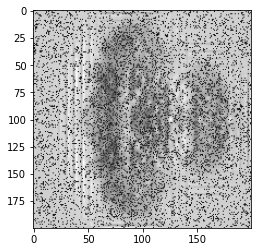

In [698]:
do_2dplot(np.exp(log_gi))
np.exp(log_gi).min(), np.exp(log_gi).max(), np.prod(np.exp(log_gi))

It doesn't work to multiply the log exp terms (of course, this is the same and multiplying the terms!). But now we can do a sum before taking the exp.

In [699]:
log_gi.sum(), np.exp(log_gi.sum())

(-24243.11709366031, 0.0)

To recover $\gamma_i$ we have to exp this. However, we can factor out a very small number in the numerator and denomenator of the $A_\alpha$ update equation, for each image $i$.

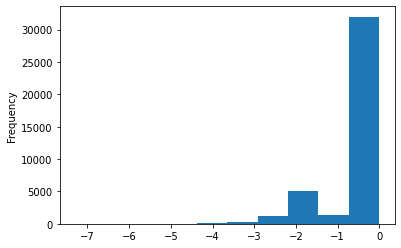

In [701]:
pd.Series(log_gi.flatten()).plot.hist()

The log term shrinks A, and many of the X terms are zero, so we can choose K to be the sum of A, which is (roughly) constant for the different rotations

-12521.833294331

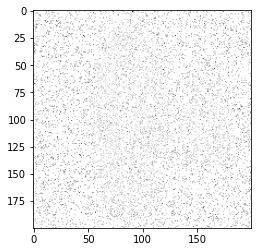

In [702]:
xlogA = x*np.log(A_prev)
do_2dplot(xlogA)
xlogA.sum()

In [703]:
np.isclose(x,0).mean()

0.804975

#### $K_i$
* K should be the same for i, but can change between i
* K should not depend on the alignment, so it can be taken out of the integral over alignments
* K can depend on the alpha being computed, but it doesn't have to

In [705]:
A_rot_ = A_rot.copy()
Alog = np.log(A_rot_)
Alog[~np.isfinite(Alog)] = Alog[np.isfinite(Alog)].min()
Alog.min()
#np.isfinite(Alog).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


-39.863984311461465

In [724]:
#K = (np.multiply(x.reshape(x.shape+(1,)),Alog) - A_rot).sum(axis=(0,1))
K = (np.multiply(x.reshape(x.shape+(1,)),Alog)).sum(axis=(0,1))

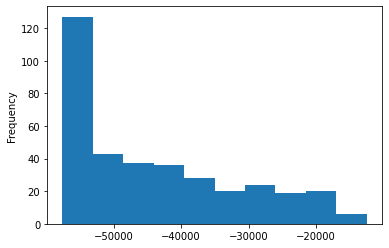

In [725]:
pd.Series(K).plot.hist()

If we scale the largest value to $+11355$, we should be able to compute over angles that have as negative a $\sum_\alpha X_{i \alpha} \ln(A_\alpha) - A_\alpha - K$ as $-11380$ (we can recode the sum as `np.float128` after we compute it. But we see that some other angles are in range and will not give zero.

This is very dependent on the scale of the observed image.

In [726]:
(K - K.max()+11355).astype(int)

array([ 11355,   7691,   5552,   3301,   1697,   -276,  -1895,  -3646,
        -5382,  -7400,  -9154, -11053, -12268, -13219, -14771, -15836,
       -16990, -18045, -19156, -20075, -21214, -22073, -22623, -23754,
       -24743, -25606, -26324, -27393, -28070, -29053, -29567, -30089,
       -30468, -30884, -31386, -31821, -31971, -32558, -32662, -33022,
       -33343, -33255, -33435, -33535, -33378, -33655, -33275, -33131,
       -33096, -33167, -32896, -32628, -32598, -32287, -32066, -31641,
       -31497, -30980, -30385, -29775, -29498, -28708, -27888, -27196,
       -26318, -25506, -24689, -23693, -22982, -21957, -21047, -19750,
       -18858, -17719, -16728, -15690, -14495, -13529, -12223, -10353,
        -8896,  -7074,  -5661,  -4146,  -2764,  -1072,    580,   2517,
         4691,   6665,  10211,   6756,   4761,   2514,    922,   -953,
        -2405,  -4269,  -5897,  -7903,  -9616, -11466, -12717, -13552,
       -15141, -16180, -17261, -18399, -19481, -20381, -21599, -22460,
      

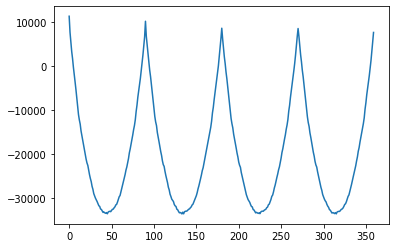

In [727]:
log_gi = (K - K.max()+11355).astype(np.float128)
gi = np.exp(log_gi)
pd.Series(log_gi).plot()

In [728]:
gi

array([2.59323582e+4931, 2.08087506e+3340, 3.00492229e+2411,
       8.85583042e+1433, 2.19513501e+0737, 5.85126094e-0121,
       3.97949526e-0824, 3.22636964e-1584, 3.08550214e-2338,
       1.17392331e-3214, 1.56850938e-3976, 4.44821827e-4801,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000, 0.00000000e+0000, 0.00000000e+0000,
       0.00000000e+0000,

# scratch

# Derivative of $x^x$
* video derivation from [blackpenredpen in 2017](https://youtu.be/l-iLg07zavc)